In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.utils import shuffle # for shuffling
import os
import cv2
import random
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
# !pip install wandb
import wandb
# !wandb login
wandb.login(key="338ff25d87248e7f3e86e98c746e32fe09553c9e")

#338ff25d87248e7f3e86e98c746e32fe09553c9e

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import gc

In [17]:
classesList = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]

In [4]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip -O nature_12K.zip
!unzip -q nature_12K.zip

--2024-04-04 13:32:50--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.207, 142.250.159.207, 142.251.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: 'nature_12K.zip'

nature_12K.zip      100%[===================>]   3.55G   243MB/s    in 15s     

2024-04-04 13:33:05 (251 MB/s) - 'nature_12K.zip' saved [3816687935/3816687935]



In [5]:
!rm nature_12K.zip

In [6]:
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
print(device)

cuda


In [8]:
resize_width = 500
resize_height= 500

In [9]:
def getDimOfLastConv(num_filters, filter_sizes, use_batch_norm=False):
    layers = []
    
    # Initial convolution layer
    layers.append(nn.Conv2d(3, num_filters[0], kernel_size=filter_sizes[0], stride=1, padding=0))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    if use_batch_norm:
        layers.append(nn.BatchNorm2d(num_filters[0]))
    
    # Subsequent convolution layers
    for i in range(1, len(num_filters)):
        layers.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=filter_sizes[i], stride=1, padding=0))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(num_filters[i]))
    
    conv_stack = nn.Sequential(*layers)
    
    image_tensor = torch.zeros([1, 3, resize_width, resize_height])
    x = conv_stack(image_tensor)
    flat = nn.Flatten()
    x = flat(x)
    return x.shape[-1]

In [10]:
class SimpleCNN(nn.Module):
  def __init__(self, num_filters, filter_sizes, activation_fn, num_neurons_dense, use_batch_norm, dropout_prob):
    super(SimpleCNN, self).__init__()

    layers = []
    
    # Initial convolution layer
    layers.append(nn.Conv2d(3, num_filters[0], kernel_size=filter_sizes[0], stride=1, padding=0))
    layers.append(activation_fn)
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    if use_batch_norm:
        layers.append(nn.BatchNorm2d(num_filters[0]))
    
    # Subsequent convolution layers
    for i in range(1, len(num_filters)):
        layers.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=filter_sizes[i], stride=1, padding=0))
        layers.append(activation_fn)
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(num_filters[i]))
    
    self.conv_stack = nn.Sequential(*layers)

    flattenNodes = getDimOfLastConv(num_filters, filter_sizes, use_batch_norm)
    self.flatten = nn.Flatten()
    self.dense = nn.Linear(flattenNodes, num_neurons_dense)
    self.dropout = nn.Dropout(dropout_prob)
    self.output = nn.Linear(num_neurons_dense, 10)

  def forward(self, x):
    x = self.conv_stack(x)  # Pass input through conv_stack
    x = self.flatten(x)  # Flatten the output of conv layers
    x = self.dense(x) # passing through dense layer
    x = self.output(x)
    return x


In [11]:
# # Defining your transformations
# transform = transforms.Compose([
#     transforms.Resize((resize_width, resize_height)),  # Resize to 256x256
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
# ])

# # Dataset
# TrainDataset = datasets.ImageFolder(root='inaturalist_12K/train', transform=transform)
# # DataLoader with shuffling
# TrainData_loader = DataLoader(TrainDataset,shuffle=True,num_workers=2,batch_size=64,pin_memory=True)

# # same for validation
# ValidationDataset = datasets.ImageFolder(root='inaturalist_12K/val', transform=transform)
# # DataLoader with shuffling
# ValidationData_loader = DataLoader(ValidationDataset, batch_size=64)


In [12]:
def load_data(train_dir, test_dir, batchSize):
    
    # Transformation
    transform = transforms.Compose([
        transforms.Resize((resize_width, resize_height)),  # Resize to 256x256
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
    ])

    # Dataset
    TrainDataset = datasets.ImageFolder(root=train_dir, transform=transform)
    class_to_idx = TrainDataset.class_to_idx

    # Initialize lists to hold indices for training and validation
    train_indices = []
    val_indices = []

    # Split indices for each class
    for class_name, class_index in class_to_idx.items():
        # Find indices of images in the current class
        class_indices = [i for i, (_, label) in enumerate(TrainDataset.samples) if label == class_index]

        # Split these indices into training and validation
        _train_indices, _val_indices = train_test_split(class_indices, test_size=0.2, random_state=42)

        # Append to the main list
        train_indices.extend(_train_indices)
        val_indices.extend(_val_indices)

    # Create subsets for training and validation
    train_subset = Subset(TrainDataset, train_indices)
    val_subset = Subset(TrainDataset, val_indices)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batchSize, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batchSize, shuffle=True, num_workers=2, pin_memory=True)

    # same for validation
    TestDataset = datasets.ImageFolder(root=test_dir, transform=transform)
    # DataLoader with shuffling
    TestData_loader = DataLoader(TestDataset,num_workers=2, batch_size=batchSize, pin_memory=True)
    
    return train_loader, val_loader, TestData_loader
    

In [13]:

def train(model, criterion, optimizer, num_epochs, train_loader, val_loader):
    for epoch in range(num_epochs):
        model.train()
#         for inputs, labels in train_loader:
        for ind, (inputs, labels) in enumerate(tqdm(train_loader, desc=f'Training Progress {epoch+1}')):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        find_accuracy(model, criterion, train_loader, "train")
        find_accuracy(model, criterion, val_loader, "validation")

def find_accuracy(model, criterion, dataLoader, dataName):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    print(f'{dataName} Loss: {val_loss/len(dataLoader)}, '
          f'{dataName} Accuracy: {100*correct/total}%\n')
    
#     wandb.log({f'{dataName}_accuracy': 100*correct/total})
#     wandb.log({f'{dataName}_loss': val_loss/len(dataLoader)})
    
def train_model(learning_rate, num_filters, filter_sizes, activation_fn, optimiser_fn, num_neurons_dense, weight_decay, dropout, useBatchNorm, batchSize, num_epochs):
    activation_dict = {'relu': nn.ReLU(), 'elu': nn.ELU(), 'selu': nn.SELU()}
    
    trainDataLoader, valDataLoader, testDataLoader = load_data(train_dir = 'inaturalist_12K/train', test_dir = 'inaturalist_12K/val', batchSize = batchSize)
    
#     num_epochs = 10
    model = SimpleCNN(num_filters=num_filters, filter_sizes=filter_sizes, 
                  activation_fn=activation_dict[activation_fn], num_neurons_dense=num_neurons_dense,
                  dropout_prob=dropout, use_batch_norm = useBatchNorm)

    criterion = nn.CrossEntropyLoss()
    if optimiser_fn == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimiser_fn == "nadam":
        optimizer = optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimiser_fn == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        # stocastic gradient decent        
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.nn.DataParallel(model,device_ids = [0,1]).to(device)


    train(model, criterion, optimizer, num_epochs, trainDataLoader, valDataLoader)
    
    return model
    #this for the sweeps
    #clearing the ram
    model.cpu()
    del model
    gc.collect()
    torch.cuda.empty_cache()


In [14]:
model = train_model(learning_rate = 1e-4, num_filters = [32,32,32,32,32], filter_sizes=[3,5,3,5,3], 
                    activation_fn = "elu", optimiser_fn ="adam", num_neurons_dense = 512, 
                    weight_decay = 0.005, dropout = 0.2, useBatchNorm = False, batchSize = 64, 
                    num_epochs = 10)
   

Training Progress 10: 100%|██████████| 125/125 [01:20<00:00,  1.54it/s]


train Loss: 1.7011550550460814, train Accuracy: 42.642830353794224%

validation Loss: 1.9258542992174625, validation Accuracy: 32.6%



In [15]:
trainDataLoader, valDataLoader, testDataLoader = load_data(train_dir = 'inaturalist_12K/train', test_dir = 'inaturalist_12K/val', batchSize = 16)
    
criterion = nn.CrossEntropyLoss()
find_accuracy(model, criterion, valDataLoader, "val")
find_accuracy(model, criterion, testDataLoader, "test")

val Loss: 1.9267212009429933, val Accuracy: 32.6%

test Loss: 1.912477294921875, test Accuracy: 32.95%



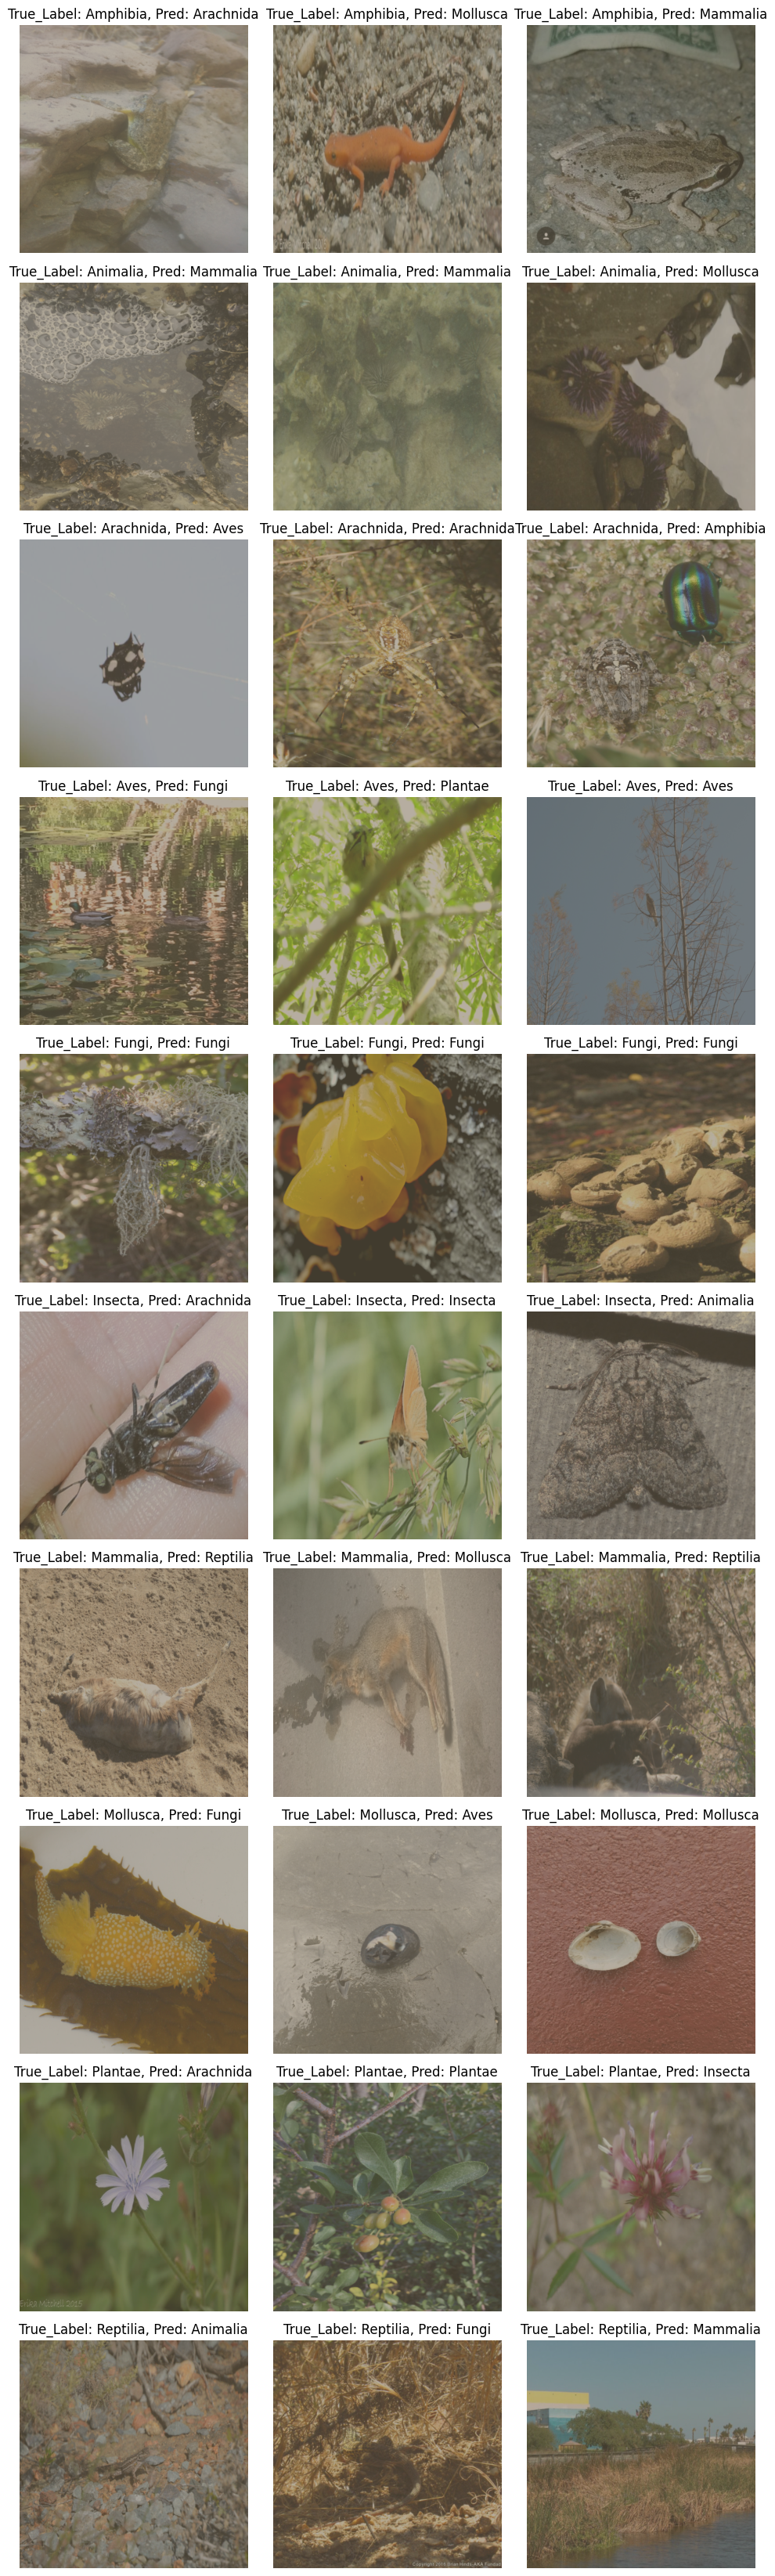

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set the model to evaluation mode

samples_per_class = {class_id: [] for class_id in range(10)}  # Assuming class IDs 0-9
max_samples = 3

with torch.no_grad(): 
    for images, labels in valDataLoader:
        if all(len(samples) >= max_samples for samples in samples_per_class.values()):
            break  # Exit early if we have enough samples
        for image, label in zip(images, labels):
            label_item = label.item()
            if len(samples_per_class[label_item]) < max_samples:
                samples_per_class[label_item].append((image, model(image.unsqueeze(0)).argmax(1).item()))

# Create the plot
fig, axes = plt.subplots(10, 3, figsize=(10, 33)) 

for class_id, samples in samples_per_class.items():
    for i, (image, prediction) in enumerate(samples):
        ax = axes[class_id, i]
        # Convert image to numpy array and normalize
        np_image = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        np_image = std * np_image + mean
        np_image = np.clip(np_image, 0, 1)
        ax.imshow(np_image)
        ax.set_title(f'True_Label: {classesList[class_id]}, Pred: {classesList[prediction]}')
        ax.axis('off')

plt.tight_layout()

# Save the figure
plt.savefig('/kaggle/working/model_predictions_grid.png', dpi=300)  
plt.show()  # Show the plot in the output


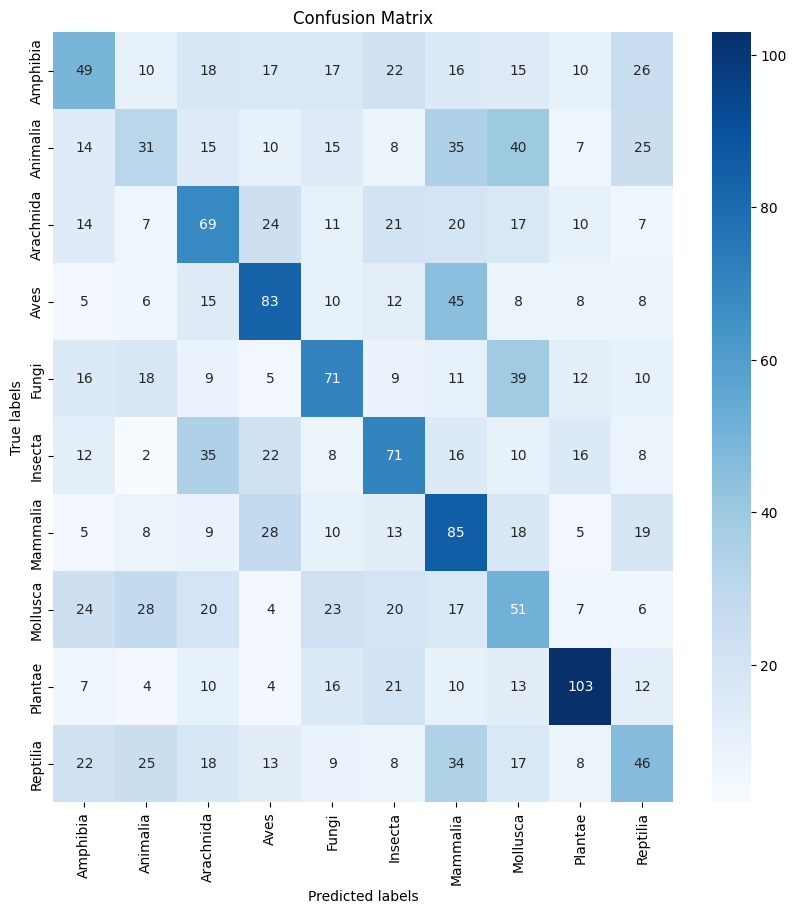

In [23]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in testDataLoader:
        data = data.to(device)
        outputs = model(data)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=classesList, yticklabels=classesList)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


In [ ]:
def main():
    wandb.init(project="Assignment 2")
    config = wandb.config
    run_name = f"{config.optimiser}_{config.activation}_{config.num_filters}_{config.batch_size}"

    # Set the run name
    wandb.run.name = run_name
    wandb.run.save()

    # Define and train the model as before
    train_model(learning_rate = config.learning_rate, num_filters = config.num_filters,
                filter_sizes = config.filter_sizes, activation_fn = config.activation, 
                optimiser_fn = config.optimiser, num_neurons_dense = config.dense_layer,
                weight_decay = config.weight_decay, dropout = config.dropout, useBatchNorm = False, 
                batchSize = config.batch_size, num_epochs = 10)
    
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep cross entropy',
    'metric': {
      'name': 'validation_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
          'values': [[32,32,32,32,32],[32,64,64,128,128],[128,128,64,64,32],[32,64,128,256,512]]
        },
        'filter_sizes': {
          'values': [[3,3,3,3,3], [5,5,5,5,5], [3,5,3,5,3]]
        },
        'weight_decay': {
            'values':[0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values':[1e-3,1e-4]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.005]
        },
        'dropout': {
            'values': [0, 0.2, 0.4]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'activation': {
            'values': ['relu', 'elu', 'selu']
        },
        'optimiser': {
            'values': ['nadam', 'adam', 'rmsprop']
        },
        'batch_norm':{
            'values': ['true','false']
        },
        'batch_size': {
            'values': [32, 64]
        },
        'dense_layer':{
            'values': [128, 256, 512]
        }
    }
}


sweep_id = wandb.sweep(sweep=sweep_config,project='Assignment 2')
wandb.agent("k4kg156v" , function = main , count = 400)

wandb.finish()